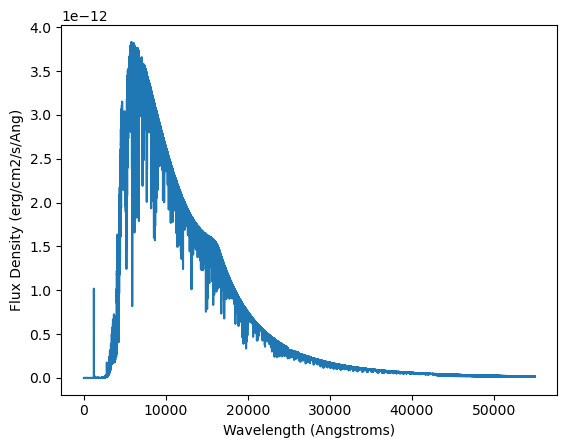

In [3]:
from astropy.io import fits
import matplotlib.pyplot as plt
spec = fits.getdata('hlsp_muscles_multi_multi_hd85512_broadband_v22_adapt-const-res-sed.fits',1)
plt.plot(spec['WAVELENGTH'],spec['FLUX'])
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Flux Density (erg/cm2/s/Ang)')
plt.show()

In [4]:
c = 3e8

def get_spectra(fits_file):
    spec = fits.getdata(fits_file,1)
    wav = spec['WAVELENGTH']
    irr_wav = spec['FLUX']
    nu = c / wav
    irr_nu = irr_wav * wav**2 / c
    return {'wl' : wav, 'F_wl': irr_wav, 'nu' : nu, 'F_nu' : irr_nu}
    
    

In [7]:
get_spectra('hlsp_muscles_multi_multi_hd85512_broadband_v22_adapt-const-res-sed.fits')

{'wl': array([4.9279747e+00, 5.9279747e+00, 6.9279747e+00, ..., 5.4996928e+04,
        5.4997928e+04, 5.4998928e+04]),
 'F_wl': array([2.88527347e-16, 2.88527347e-16, 2.76736009e-16, ...,
        1.32960863e-14, 1.65542242e-14, 1.71431711e-14]),
 'nu': array([6.08769359e+07, 5.06075034e+07, 4.33026985e+07, ...,
        5.45485014e+03, 5.45475095e+03, 5.45465177e+03]),
 'F_nu': array([2.33562259e-23, 3.37970202e-23, 4.42748405e-23, ...,
        1.34053894e-13, 1.66909184e-13, 1.72853570e-13])}